In [49]:
# ====== IMPORT LIBRARIES ======
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import kagglehub

# ====== LOAD DATA ======
# Download dataset from Kaggle
path = kagglehub.dataset_download("altruistdelhite04/gold-price-data")
df = pd.read_csv(path + "/gld_price_data.csv")

Using Colab cache for faster access to the 'gold-price-data' dataset.


In [50]:
# ====== DATA INSPECTION ======
print("First 5 rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nMissing values per column:")
print(df.isnull().sum())

# Fill missing values (if any)
df.fillna(method='ffill', inplace=True)

First 5 rows:
       Date          SPX        GLD        USO     SLV   EUR/USD
0  1/2/2008  1447.160034  84.860001  78.470001  15.180  1.471692
1  1/3/2008  1447.160034  85.570000  78.370003  15.285  1.474491
2  1/4/2008  1411.630005  85.129997  77.309998  15.167  1.475492
3  1/7/2008  1416.180054  84.769997  75.500000  15.053  1.468299
4  1/8/2008  1390.189941  86.779999  76.059998  15.590  1.557099

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     2290 non-null   object 
 1   SPX      2290 non-null   float64
 2   GLD      2290 non-null   float64
 3   USO      2290 non-null   float64
 4   SLV      2290 non-null   float64
 5   EUR/USD  2290 non-null   float64
dtypes: float64(5), object(1)
memory usage: 107.5+ KB
None

Missing values per column:
Date       0
SPX        0
GLD        0
USO        0
SLV        0
EUR/USD    0
dtype:

/tmp/ipython-input-1554279933.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [51]:

# ====== FEATURE ENGINEERING ======
# Convert Date to datetime and extract features
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

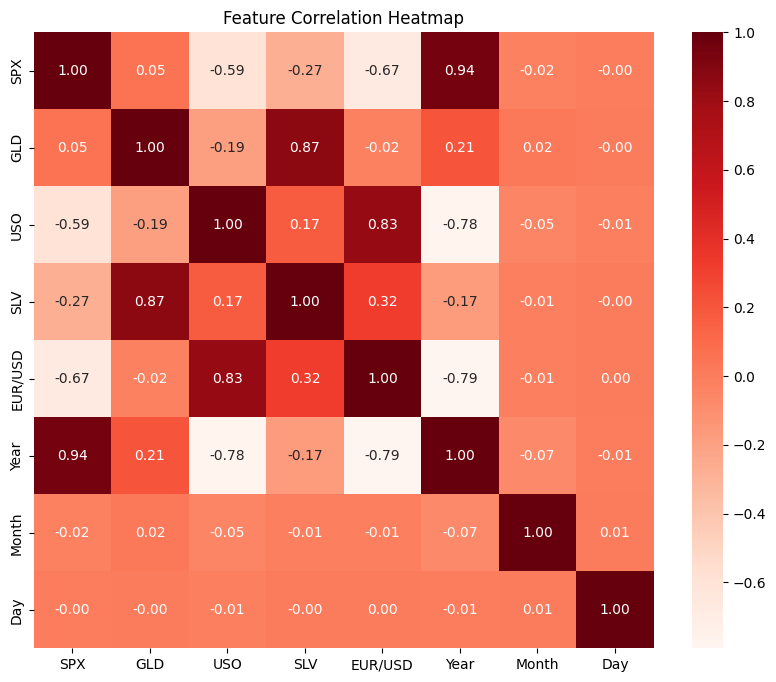

In [52]:
# ====== EXPLORATORY DATA ANALYSIS ======
# Correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.drop('Date', axis=1).corr(), annot=True, fmt='.2f', cmap='Reds')
plt.title('Feature Correlation Heatmap')
plt.show()

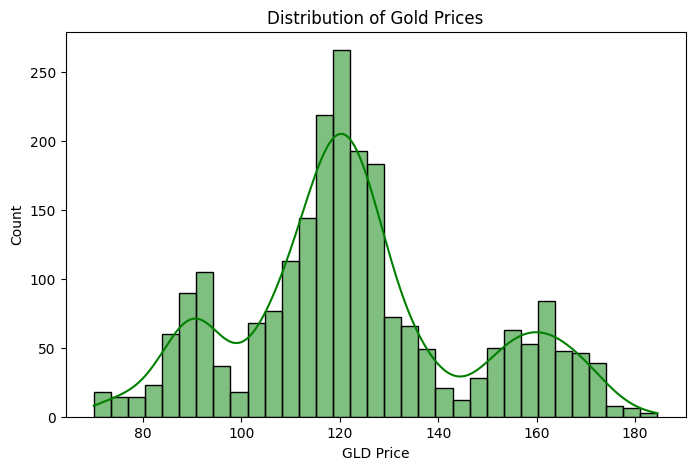

In [53]:
# Distribution of GLD prices
plt.figure(figsize=(8,5))
sns.histplot(df['GLD'], kde=True, color='green')
plt.title('Distribution of Gold Prices')
plt.xlabel('GLD Price')
plt.show()


In [54]:
# ====== FEATURE SELECTION ======
X = df.drop(['Date','GLD'], axis=1)
Y = df['GLD']


In [55]:
# Split dataset into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [56]:
# ====== MODEL TRAINING ======
regressor = RandomForestRegressor(n_estimators= 200, min_samples_split= 5, max_depth= 20)
regressor.fit(X_train, Y_train)

RandomForestRegressor(max_depth=20, min_samples_split=5, n_estimators=200)

In [57]:

# ====== PREDICTION ======
Y_pred = regressor.predict(X_test)

In [58]:
# ====== MODEL EVALUATION ======
print("R² Score:", metrics.r2_score(Y_test, Y_pred))
print("Mean Absolute Error (MAE):", metrics.mean_absolute_error(Y_test, Y_pred))
print("Mean Squared Error (MSE):", metrics.mean_squared_error(Y_test, Y_pred))
print("Root Mean Squared Error (RMSE):", np.sqrt(metrics.mean_squared_error(Y_test, Y_pred)))

R² Score: 0.9960018354244072
Mean Absolute Error (MAE): 0.9552275196253828
Mean Squared Error (MSE): 2.1921932196519167
Root Mean Squared Error (RMSE): 1.4806056935092196


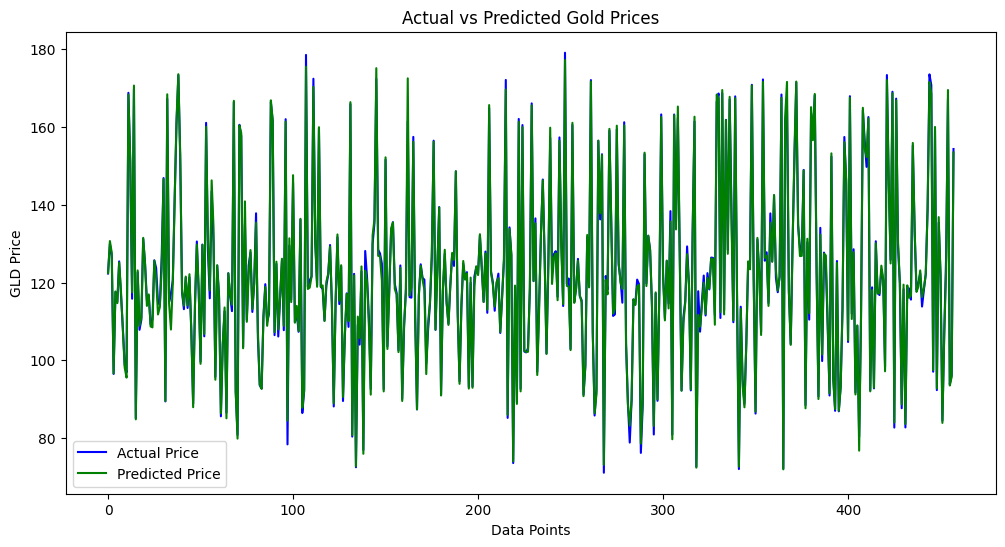

In [59]:

# ====== PLOT ACTUAL VS PREDICTED ======
plt.figure(figsize=(12,6))
plt.plot(Y_test.values, color='blue', label='Actual Price')
plt.plot(Y_pred, color='green', label='Predicted Price')
plt.title('Actual vs Predicted Gold Prices')
plt.xlabel('Data Points')
plt.ylabel('GLD Price')
plt.legend()
plt.show()

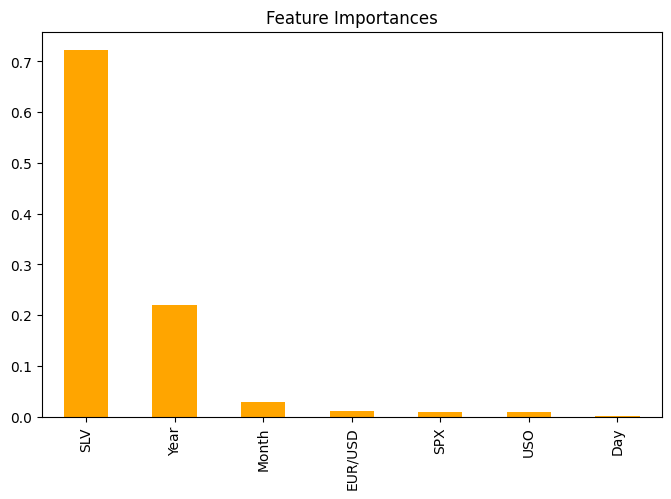

In [60]:


# ====== FEATURE IMPORTANCE ======
feature_importances = pd.Series(regressor.feature_importances_, index=X.columns)
feature_importances.sort_values(ascending=False).plot(kind='bar', figsize=(8,5), color='orange')
plt.title('Feature Importances')
plt.show()


In [61]:
# ====== OPTIONAL: HYPERPARAMETER TUNING ======
# Uncomment below to perform RandomizedSearchCV for better model

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf_random = RandomizedSearchCV(estimator=regressor, param_distributions=param_grid,
                               scoring='r2', cv=3, n_iter=10, random_state=42)
rf_random.fit(X_train, Y_train)
print("Best Parameters:", rf_random.best_params_)
best_model = rf_random.best_estimator_


Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'max_depth': 20}


In [63]:
print(X.columns)

Index(['SPX', 'USO', 'SLV', 'EUR/USD', 'Year', 'Month', 'Day'], dtype='object')


In [64]:
def predict_gold_price_auto(date, input_features, model):
    """
    Predict gold price using trained RandomForest model.
    Automatically extracts Year, Month, Day from a date.

    Parameters:
    - date: string in 'YYYY-MM-DD' format
    - input_features: dict with keys 'SPX', 'USO', 'SLV', 'EUR/USD'
    - model: trained RandomForestRegressor

    Returns:
    - predicted_price: float
    """
    import pandas as pd

    # Extract Year, Month, Day from date
    date = pd.to_datetime(date)
    input_features['Year'] = date.year
    input_features['Month'] = date.month
    input_features['Day'] = date.day

    # Convert to DataFrame
    input_df = pd.DataFrame([input_features])

    # Make sure columns match model training
    input_df = input_df[['SPX', 'USO', 'SLV', 'EUR/USD', 'Year', 'Month', 'Day']]

    # Predict
    predicted_price = model.predict(input_df)[0]
    return predicted_price

# ====== EXAMPLE USAGE ======
new_features = {
    'SPX': 4500,
    'USO': 60.5,
    'SLV': 23.1,
    'EUR/USD': 1.08
}

predicted_price = predict_gold_price_auto("2025-12-21", new_features, regressor)
print(f"Predicted Gold Price: ${predicted_price:.2f}")


Predicted Gold Price: $138.73


 further test
  to a time-series approach using LSTM or Prophet,

First 10 predictions vs actual values:
          Actual   Predicted
2178  122.320000  122.471409
1271  129.899994  130.668443
1268  126.980003  127.660379
44     96.500000   96.615900
2025  117.580002  117.711262
1583  115.000000  114.702902
2210  125.440002  125.165078
2014  116.930000  117.655790
1699  108.220001  107.994870
368    98.830002   98.123277

Model Evaluation on Test Set:
R² Score: 0.9960
Mean Absolute Error (MAE): 0.9552
Mean Squared Error (MSE): 2.1922
Root Mean Squared Error (RMSE): 1.4806


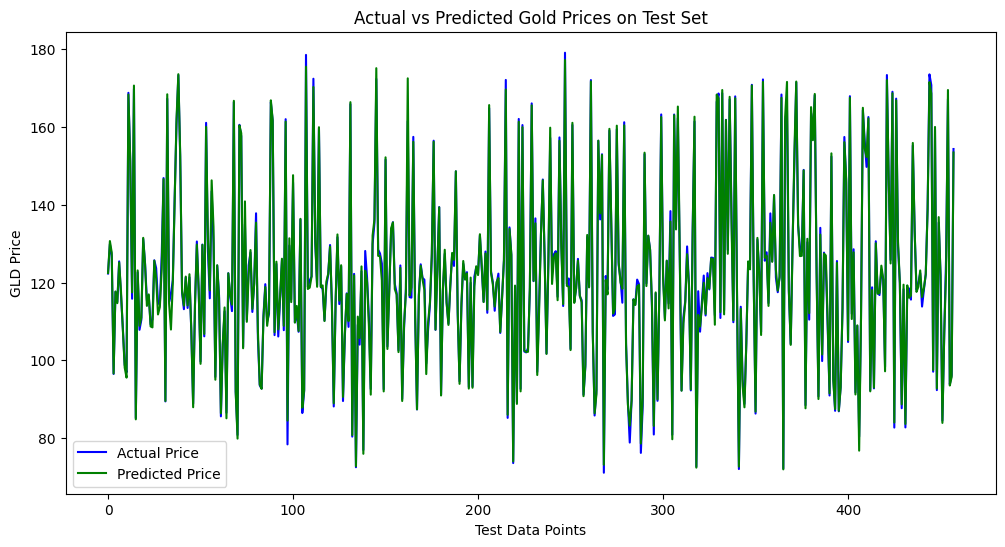

'\nfor idx in Y_test.index:\n    actual = Y_test.loc[idx]\n    predicted = Y_pred[Y_test.index.get_loc(idx)]\n    print(f"Date: {df.loc[idx, \'Date\'].date()}, Actual: {actual}, Predicted: {predicted:.2f}")\n'

In [65]:

# ====== EVALUATION ON PAST DATES ======
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import numpy as np

# Predict on the test set
Y_pred = regressor.predict(X_test)

# Create a DataFrame with actual and predicted values
results = pd.DataFrame({
    'Actual': Y_test.values,
    'Predicted': Y_pred
}, index=Y_test.index)

print("First 10 predictions vs actual values:")
print(results.head(10))

# ====== ERROR METRICS ======
r2 = metrics.r2_score(Y_test, Y_pred)
mae = metrics.mean_absolute_error(Y_test, Y_pred)
mse = metrics.mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)

print("\nModel Evaluation on Test Set:")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# ====== PLOT ACTUAL VS PREDICTED ======
plt.figure(figsize=(12,6))
plt.plot(Y_test.values, color='blue', label='Actual Price')
plt.plot(Y_pred, color='green', label='Predicted Price')
plt.title('Actual vs Predicted Gold Prices on Test Set')
plt.xlabel('Test Data Points')
plt.ylabel('GLD Price')
plt.legend()
plt.show()

# ====== OPTIONAL: Show prediction for each test date ======
# Uncomment if you want a detailed row-by-row comparison
"""
for idx in Y_test.index:
    actual = Y_test.loc[idx]
    predicted = Y_pred[Y_test.index.get_loc(idx)]
    print(f"Date: {df.loc[idx, 'Date'].date()}, Actual: {actual}, Predicted: {predicted:.2f}")
"""
